In [1]:
import numpy as np
import cvxpy as cp
import osbdo as ob

In [2]:
import time
import random


np.random.seed(0)
random.seed(0)

# Problem description
section 4.1 in https://web.stanford.edu/~boyd/papers/os_bundle_distr_opt.html 

# Create parameters

In [3]:
ms = [20, 30, 40, 25, 35]
ns = [30, 40, 25, 35, 20]
params = ob.sc_params(ms, ns)

# Distributed solution

In [4]:
agents = ob.sc_agents(params)
g = ob.sc_coupling(params, agents)
prob = ob.Problem(agents = agents, g = g)

In [5]:
max_iter = 150
start_time = time.time()
x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)
print(f"elapsed time = {time.time() - start_time}")

k=0, rel_gap=inf, L=-2074.3559134842617, U=4409.906115002427, L0=-2074.3559134842617


/Users/parshakova.tanya/opt/anaconda3/envs/osbdo/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=20, rel_gap=0.8122545094140892, L=-122.13992577144882, U=-67.3966736664031, L0=-122.13992577144882
rho=279.46693671842814


/var/folders/13/wyn3w3nx7ks002_qzk18rz7h0000gn/T/ipykernel_92602/1978256884.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)


k=40, rel_gap=0.19602441087308206, L=-91.04475481672966, U=-76.12282323758609, L0=-91.04475481672966
k=60, rel_gap=0.04510579117371726, L=-83.94942802990954, U=-80.32624901602472, L0=-83.94942802990954
k=80, rel_gap=0.01632838758893771, L=-81.99157901146293, U=-80.67429780838228, L0=-81.99157901146293
k=100, rel_gap=0.006971889045994356, L=-81.5364207244836, U=-80.9718936660002, L0=-81.5364207244836
k=120, rel_gap=0.003168766193729472, L=-81.32861234924917, U=-81.07171503936476, L0=-81.32861234924917
k=140, rel_gap=0.0013314321286080823, L=-81.21551613933684, U=-81.1075269720543, L0=-81.21551613933684
rel_gap=0.001148188456967842, L=-81.20488961830642, U=-81.11175803400741
elapsed time = 175.9477198123932


# Centralized solution

In [6]:
h_cvx, x_cvx, prob_cvx = ob.cvx_supply_chain(params=params)

In [7]:
h_cvx, prob.upper_bnd[-1]

(-81.1232713273431, -81.11175803400741)

# Plot

i=58, omega_k=0.051093777569073635, omega_true=0.00982482952520857
i=90, omega_k=0.009801165361139053, omega_true=0.0027527418650296572


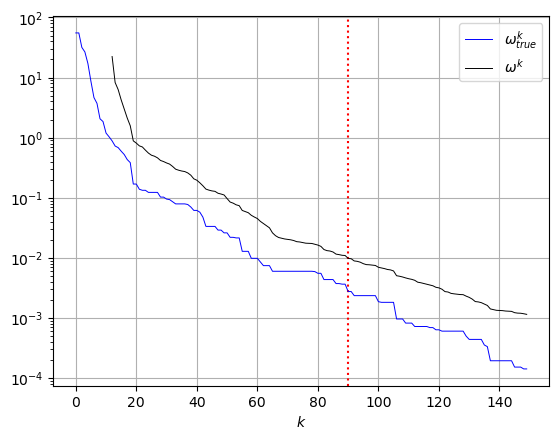

In [8]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx, file_name='sc_osbdo.pdf')

i=58, omega_k=0.051093777569073635, omega_true=0.00982482952520857
i=90, omega_k=0.009801165361139053, omega_true=0.0027527418650296572


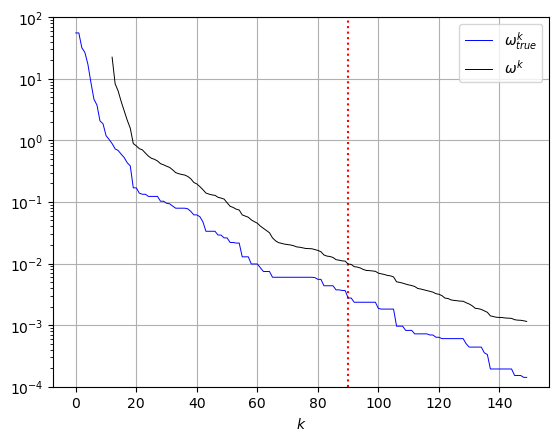

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_true_rel_gap_uk(*, lk, uk, h_true, title='', eps={'eps_rel': 10**(-2), \
                        'eps_abs': 10**(-3)}, y_min=None, y_max=None, fontsize=10,  file_name=None):
    Uk = np.array(uk)
    Lk = np.array(lk)
    start_point = 0
    for j in range(len(Uk)):
        if Uk[j]==np.inf or Lk[j]==np.inf or np.abs(Uk[j])<1e-5 or np.abs(Lk[j])<1e-5:
            start_point = j+1
    Uk = Uk[start_point:]
    Lk = Lk[start_point:]
    fig, ax1 = plt.subplots()
    fig.set_dpi(100)
    lwd = 0.7
    ax1.grid()
    plt.title(title,fontsize=fontsize)
    gap1 = (Uk-h_true)/np.abs(h_true)
    gap2 = (Uk-Lk)/np.minimum(np.abs(Uk), np.abs(Lk))
    stop = np.inf
    for i in range(len(Uk)):
        if Uk[i]*Lk[i]<0:
            gap2[i] = np.inf
    stop=np.inf
    flag = False
    for i in range(len(Uk)):
        if not flag and (Uk[i]-h_true < eps['eps_abs'] \
                            or (Uk[i]-h_true < eps['eps_rel']*min(np.abs(Uk[i]),np.abs(Lk[i])) and Uk[i]*Lk[i]>0)):
            flag = True
            print(f"{i=}, omega_k={gap2[i]}, omega_true={gap1[i]}")

        if Uk[i]-Lk[i] < eps['eps_abs'] \
                            or (Uk[i]-Lk[i]<eps['eps_rel']*min(np.abs(Uk[i]),np.abs(Lk[i])) and Uk[i]*Lk[i]>0):
            stop = i
            print(f"{i=}, omega_k={gap2[i]}, omega_true={gap1[i]}")
            break
    ax1.axvline(stop, color='r', linestyle=':')
    ax1.plot(gap1,linewidth=lwd,label=r'$\omega_{true}^{k}$',color='b')
    ax1.set_xlabel(r'$k$',fontsize=fontsize)
    ax1.set_yscale('log')
    if y_min is not None and y_max is not None:
        ax1.set_ylim([y_min, y_max])
    ax1.plot(gap2,linewidth=lwd, color='black',label=r'$\omega^{k}$')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels , loc=0, fontsize=fontsize)
    plt.show() 
    if file_name:
        fig.savefig(file_name, bbox_inches='tight')


plot_true_rel_gap_uk(y_min=1e-4, y_max=1e2, lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx, file_name='sc_osbdo_bounds.pdf')

In [10]:
A, b, l, u, _, grad_g_val = ob.sc_data_matrix_format(params)

In [11]:
data = {"params" : params, \
        "A": A, "b": b.reshape(-1, 1), \
        "grad_g_val" : grad_g_val.reshape(-1, 1), \
        "lower_bound" : l.reshape(-1, 1), "upper_bound" : u.reshape(-1, 1), \
        "h_cvx":h_cvx,\
        "x_cvx": x_cvx.reshape(-1, 1)}

In [12]:
import pandas as pd

pd.to_pickle(data, "sc_data.pickle")

In [13]:
from numpy import genfromtxt

jl_prox_fx0 = genfromtxt("/Users/parshakova.tanya/Documents/Distributed_Optimization/BundleMethod/examples/jl_prox_fx0.csv")

i=331, omega_true=0.00980115533740764


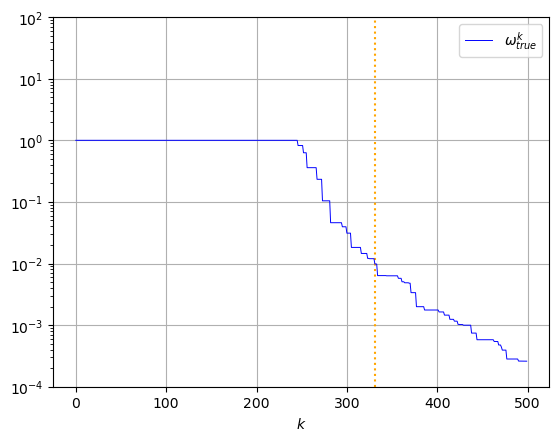

In [14]:
ob.plot_uk_rel_gap_uk(y_min=1e-4, y_max=1e2, uk = jl_prox_fx0, h_true = h_cvx, file_name='sc_jl_prox_bounds.pdf')

In [15]:
jl_tr_fx0 = genfromtxt("/Users/parshakova.tanya/Documents/Distributed_Optimization/BundleMethod/examples/jl_tr_fx0.csv")

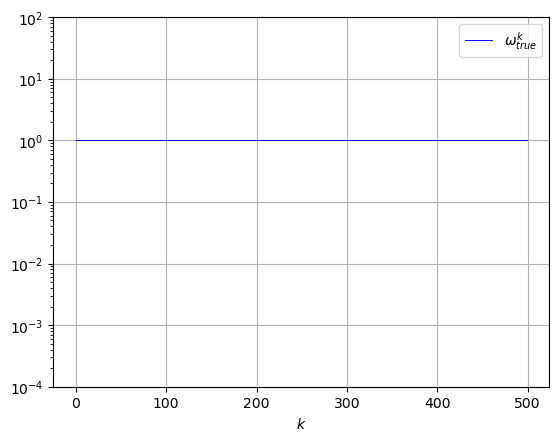

In [17]:
ob.plot_uk_rel_gap_uk(y_min=1e-4, y_max=1e2, uk = jl_tr_fx0, h_true = h_cvx, file_name='sc_jl_tr_bounds.pdf')